In [3]:
# %%
# Step 0: Install necessary libraries
# You'll need umap-learn for the algorithm and plotly for interactive plotting.
# %pip install polars pandas numpy umap-learn plotly scikit-learn

# %%
import polars as pl
import numpy as np
import umap
import requests
import time

In [1]:
import polars as pl

# --- 1. LOAD YOUR DATA ---
# Load your final, fine-tuned embeddings parquet file.
# This file should contain the card name and its high-dimensional embedding vector.
print("Loading embeddings...")
try:
    df_embeddings = pl.read_parquet("mtg_embeddings.parquet")
    # Also load the full card data to get other attributes like image URIs
    # Select only the necessary columns from the full data
    df_full_data = pl.read_parquet("mtg_data.parquet").select(["name", "scryfallId", "manaCost", "type"])
except Exception as e:
    print(f"Error loading data. Make sure 'mtg_embeddings.parquet' and 'mtg_data.parquet' are present.")
    print(f"Error: {e}")
    exit()

Loading embeddings...


In [4]:
# --- 2. SELECT THE SUBSET OF CARDS TO VISUALIZE ---
# Here, we'll get a list of all functional counterspells using the Scryfall API.
# This is a robust way to define our subset.
def get_card_names_from_scryfall(query):
    url = "https://api.scryfall.com/cards/search"
    params = {'q': query}
    card_names = []
    print(f"Fetching card names from Scryfall for query: '{query}'")
    while True:
        try:
            response = requests.get(url, params=params)
            response.raise_for_status()
            data = response.json()
            for card in data['data']:
                # We only want the card name
                if 'card_faces' not in card: # Exclude split cards for simplicity
                    card_names.append(card['name'])
            if data['has_more']:
                url = data['next_page']
                params = None
                time.sleep(0.1)
            else:
                break
        except Exception as e:
            print(f"Scryfall API error: {e}")
            break
    return list(set(card_names)) # Return unique names

# Define the subset we want to explore
counterspell_names = get_card_names_from_scryfall("function:counterspell")
print(f"Found {len(counterspell_names)} unique counterspell cards.")

# Filter your main dataframe to get only the embeddings for these cards
df_subset = df_embeddings.filter(pl.col("name").is_in(counterspell_names))

Fetching card names from Scryfall for query: 'function:counterspell'
Found 512 unique counterspell cards.


In [5]:
# --- 3. APPLY UMAP ---
# Extract the high-dimensional embeddings for our subset
high_dim_embeddings = np.vstack(df_subset["embedding"].to_numpy())

print(f"\nRunning UMAP on {high_dim_embeddings.shape[0]} embeddings of dimension {high_dim_embeddings.shape[1]}...")

# Configure and run the UMAP algorithm.
# n_neighbors: Controls how UMAP balances local vs. global structure. Smaller values focus more on local structure.
# min_dist: Controls how tightly UMAP is allowed to pack points together.
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='cosine', # Use cosine distance, as it's standard for normalized text embeddings
    random_state=42
)

# Project the embeddings down to 2 dimensions
embedding_2d = reducer.fit_transform(high_dim_embeddings)

print("UMAP projection complete.")


Running UMAP on 510 embeddings of dimension 768...


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP projection complete.


In [ ]:
# --- 4. PREPARE DATA FOR PLOTTING ---
# Add the new 2D coordinates back to our subset dataframe
df_plot = df_subset.with_columns([
    pl.Series(name="x", values=embedding_2d[:, 0]),
    pl.Series(name="y", values=embedding_2d[:, 1])
])

# Join with full data to get image URIs for the hover tooltips
df_plot = df_plot.join(df_full_data, on="name", how="left")

# Extract the normal-sized image URI from the 'image_uris' struct
# Also handle potential missing images gracefully
def get_image_url(image_uris):
    if image_uris and 'normal' in image_uris:
        return image_uris['normal']
    return 'https://placehold.co/488x680?text=No+Image' # Placeholder

df_plot = df_plot.with_columns(
    pl.col("image_uris").apply(get_image_url).alias("image_url")
)

In [ ]:
# --- 5. CREATE THE INTERACTIVE VISUALIZATION ---
print("\nGenerating interactive plot...")

# Use Plotly Express for easy and powerful plotting
fig = px.scatter(
    df_plot.to_pandas(), # Plotly works best with pandas DataFrames
    x="x",
    y="y",
    hover_name="name", # This will be the title of the hover tooltip
    hover_data={ # Custom data to show in the tooltip
        "x": False, # Hide x coordinate
        "y": False, # Hide y coordinate
        "image_url": True # We'll use this for the image
    },
    title="UMAP Visualization of Counterspell Embeddings",
    template="plotly_dark"
)

# Customize the hover template to show an image
# This uses HTML within the hover template.
fig.update_traces(
    hovertemplate="<b>%{hovertext}</b><br><br><img src='%{customdata[0]}' width='200'><extra></extra>"
)

# Improve the layout
fig.update_layout(
    xaxis=dict(title='', showticklabels=False, zeroline=False),
    yaxis=dict(title='', showticklabels=False, zeroline=False),
    width=900,
    height=800
)

# Show the figure
fig.show()


Generating matplotlib plot...


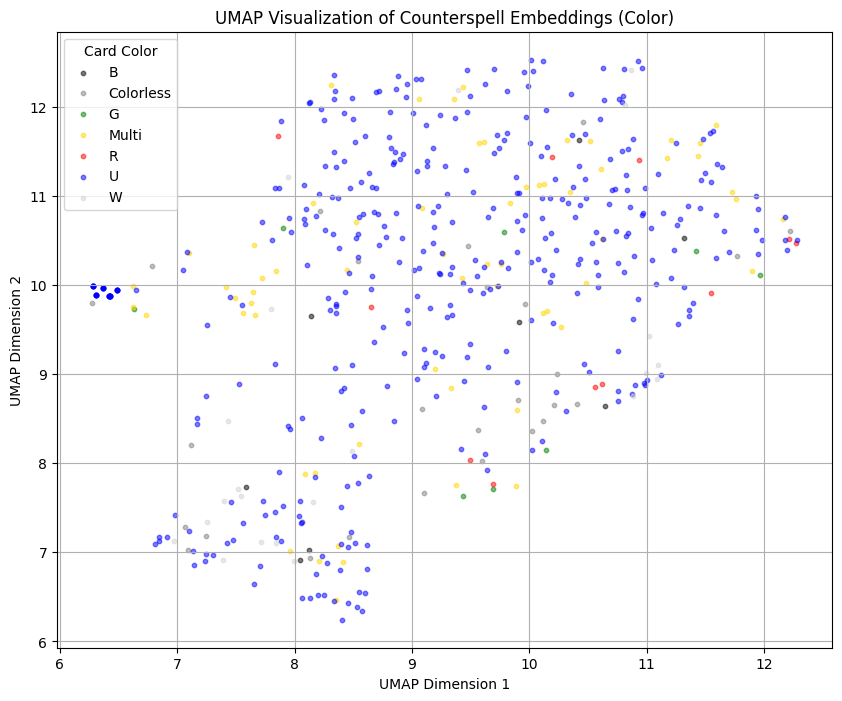

Matplotlib plot generated.


In [12]:
# --- 5. CREATE THE MATPLOTLIB VISUALIZATION ---
import matplotlib.pyplot as plt
import re

print("\nGenerating matplotlib plot...")

df_plot = df_subset.with_columns([
    pl.Series(name="x", values=embedding_2d[:, 0]),
    pl.Series(name="y", values=embedding_2d[:, 1])
])

# Join with full data to get manaCost for card color
df_plot = df_plot.join(df_full_data.select(["name", "manaCost"]), on="name", how="left")

# Convert the Polars DataFrame to a Pandas DataFrame for Matplotlib
df_plot_pandas = df_plot.to_pandas()

# Function to extract colors from mana cost
def extract_colors_from_mana_cost(mana_cost):
    if not mana_cost:
        return 'Colorless'
    colors = set()
    # Find all color symbols within curly braces
    matches = re.findall(r'\{([WUBRG])\}', mana_cost)
    for match in matches:
        colors.add(match)

    if not colors:
        return 'Colorless'
    elif len(colors) == 1:
        return list(colors)[0]
    else:
        return 'Multi' # Classify multicolor cards as 'Multi'

df_plot_pandas['main_color'] = df_plot_pandas['manaCost'].apply(extract_colors_from_mana_cost)

plt.figure(figsize=(10, 8))

# Define colors for each main color category (you can customize this)
color_map = {
    'W': 'lightgray', # Using lightgray for White for better visibility on dark background
    'U': 'blue',
    'B': 'black',
    'R': 'red',
    'G': 'green',
    'Multi': 'gold', # Color for multicolor
    'Colorless': 'gray'
}

# Plot points colored by the main_color
for color, group in df_plot_pandas.groupby('main_color'):
    plt.scatter(group['x'], group['y'], s=10, alpha=0.5, label=color, color=color_map.get(color, 'gray')) # Use color_map for colors

plt.title("UMAP Visualization of Counterspell Embeddings (Color)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(True)
plt.legend(title="Card Color") # Add a legend
plt.show()

print("Matplotlib plot generated.")


Generating matplotlib plot (Free vs Non-Free)...


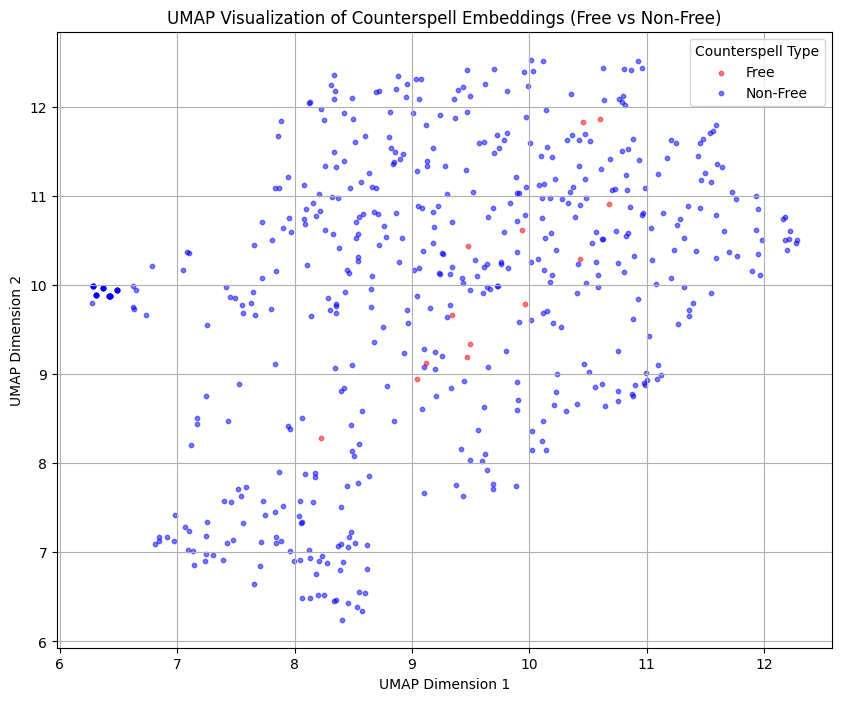

Matplotlib plot (Free vs Non-Free) generated.


In [11]:
# --- 6. CREATE MATPLOTLIB VISUALIZATION - Free vs Non-Free ---
import matplotlib.pyplot as plt

print("\nGenerating matplotlib plot (Free vs Non-Free)...")

# Use the existing df_plot_pandas which contains the UMAP coordinates and card names
# df_plot_pandas = df_plot.to_pandas() # Already done in the previous cell

# Define the list of free counterspells
free_counterspells = ['Daze', 'Disrupting Shoal', 'Fierce Guardianship', 'Flare of Denial', 'Foil', 'Force of Negation', 'Force of Will', 'Mental Misstep', 'Mindbreak Trap', 'Not of This World', 'Pact of Negation', 'Subtlety', 'Thwart']

# Categorize each card as 'Free' or 'Non-Free'
df_plot_pandas['free_status'] = df_plot_pandas['name'].apply(lambda name: 'Free' if name in free_counterspells else 'Non-Free')

plt.figure(figsize=(10, 8))

# Define colors for Free and Non-Free categories
free_color_map = {
    'Free': 'red',
    'Non-Free': 'blue'
}

# Plot points colored by free_status
for status, group in df_plot_pandas.groupby('free_status'):
    plt.scatter(group['x'], group['y'], s=10, alpha=0.5, label=status, color=free_color_map.get(status, 'gray'))

plt.title("UMAP Visualization of Counterspell Embeddings (Free vs Non-Free)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(True)
plt.legend(title="Counterspell Type")
plt.show()

print("Matplotlib plot (Free vs Non-Free) generated.")